In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

In [58]:
df = pd.read_csv('Data/preprocessed_df.csv')
df.head()

,Unnamed: 0,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Power,Temp_diff,tool_wear_torque_product
0,0,1,-0.952389,-0.947360,0.068185,0.282200,-1.695984,0,0,0,0,0,0,0.629443,0.498849,-1.526544
1,1,0,-0.902393,-0.879959,-0.729472,0.633308,-1.648852,0,0,0,0,0,0,0.512456,0.498849,-1.477401
2,2,0,-0.952389,-1.014761,-0.227450,0.944290,-1.617430,0,0,0,0,0,0,1.376889,0.398954,-1.439155
3,3,0,-0.902393,-0.947360,-0.590021,-0.048845,-1.586009,0,0,0,0,0,0,-0.330009,0.398954,-1.428717
4,4,0,-0.902393,-0.879959,-0.729472,0.001313,-1.554588,0,0,0,0,0,0,-0.357824,0.498849,-1.399175


In [59]:
df.shape

(10000, 16)

In [60]:
df.columns

Index(['Unnamed: 0', 'Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Power',
       'Temp_diff', 'tool_wear_torque_product'],
      dtype='object')

+ Cleaning up the feature names as some models like XGBoost expects all feature names to be clean, without any special characters.

In [61]:
df.columns = df.columns.str.replace(r'\[.*?\]', '', regex=True)  # Remove anything inside brackets []

In [62]:
df.columns

Index(['Unnamed: 0', 'Type', 'Air temperature ', 'Process temperature ',
       'Rotational speed ', 'Torque ', 'Tool wear ', 'Machine failure', 'TWF',
       'HDF', 'PWF', 'OSF', 'RNF', 'Power', 'Temp_diff',
       'tool_wear_torque_product'],
      dtype='object')

In [63]:
# Dropping columns that are not needed for training
df = df.drop(columns=['Unnamed: 0', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'])

In [64]:
# Separate features (X) and target (y)
X = df.drop(columns=['Machine failure'])  # Features
y = df['Machine failure']  # Target variable

### Splitting the Data
#### Training Data: 70% and Test Data: 30%

In [65]:
from sklearn.model_selection import train_test_split

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [67]:
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (7000, 9), (7000,)
Test set shape: (3000, 9), (3000,)


In [68]:
X_train.head()

,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Power,Temp_diff,tool_wear_torque_product
1888,1,-1.102378,-1.756171,2.026070,-1.573658,0.330694,-1.348877,-0.400212,-0.417476
4858,0,1.847388,1.546473,-1.058575,1.104796,-0.046362,0.866498,-1.399170,0.368074
8990,0,-1.402354,-1.419166,-0.255340,-0.159193,0.597776,-0.258614,0.698641,0.457021
4901,1,1.797392,1.546473,0.508849,-0.761093,1.807498,-0.701995,-1.299274,1.029758
7957,2,0.447499,1.276869,3.353638,-2.356128,-1.020424,-2.419126,0.998328,-1.275520


#### Functions for Model Evaluation

In [69]:
from sklearn.metrics import (accuracy_score, f1_score, recall_score, precision_score, 
    classification_report, precision_recall_curve, auc,confusion_matrix, ConfusionMatrixDisplay)

In [70]:
# Dictionary to store evaluation metrics score for each model...
model_score = {}

In [71]:
def evaluate_model(y_true, y_pred, model_name="Model", average='macro',plot_pr_curve=False):
    
    # Calculating metrics
    accuracy = round(accuracy_score(y_true, y_pred) * 100, 2)
    f1 = round(f1_score(y_true, y_pred, average=average,zero_division=0) * 100, 2)
    recall = round(recall_score(y_true, y_pred, average=average,zero_division=0) * 100, 2)
    precision = round(precision_score(y_true, y_pred, average=average,zero_division=0) * 100, 2)

    # Printing results
    print(f"{model_name} Evaluation Metrics:")
    print(f"Accuracy: {accuracy}%")
    print(f"F1 Score: {f1}%")
    print(f"Recall: {recall}%")
    print(f"Precision: {precision}%")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))

    if plot_pr_curve:
        precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred)
        pr_auc = auc(recalls, precisions)
        
        print(f"\nPR AUC: {round(pr_auc * 100, 2)}%")
        
        # Plot PR curve
        plt.figure(figsize=(5, 5))
        plt.plot(recalls, precisions, marker='.', label=f'PR Curve (AUC = {round(pr_auc * 100, 2)}%)')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'{model_name} Precision-Recall Curve')
        plt.legend(loc='best')
        plt.grid(True)
        plt.show()

    
    return {
        "accuracy": accuracy,
        "f1_score": f1,
        "recall": recall,
        "precision": precision,
        "PR AUC(%)": round(pr_auc * 100, 2)
    }

In [72]:
def plot_confusion_matrix(cm,title='Confusion Matrix',cmap=plt.cm.Reds,display_metrics=True):
    plt.figure(figsize=(7, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    #0 -> No Failure | 1 -> Failure 
    classes = ['No Failure', 'Failure'] 
    plt.xticks(ticks=np.arange(len(classes)), labels=classes)
    plt.yticks(ticks=np.arange(len(classes)), labels=classes)

     # Add text annotations to each cell
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f'{cm[i, j]}',
                     ha='center', va='center',
                     color='white' if cm[i, j] > cm.max() / 2. else 'black')
            
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.grid(False)

### Model Building

* Our dataset is imbalanced, so we'll use models and techniques which are well-suited for handling imbalanced datasets.

#### 1. Logistic Regression

In [73]:
from sklearn.linear_model import LogisticRegression

* Since our dataset is relatively small (7,000 samples), the liblinear solver is a good choice. It is efficient for smaller datasets and works well for binary classification tasks.
* class_weight='balanced': Adjusts the weights inversely proportional to the class frequencies, making the model give more importance to the minority class.

In [74]:
lr = LogisticRegression(solver='liblinear', max_iter=1000, class_weight='balanced', random_state=42)
lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='liblinear')

Logistic Regression Evaluation Metrics:
Accuracy: 86.43%
F1 Score: 60.86%
Recall: 84.46%
Precision: 58.52%

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.87      0.92      2898
           1       0.18      0.82      0.29       102

    accuracy                           0.86      3000
   macro avg       0.59      0.84      0.61      3000
weighted avg       0.97      0.86      0.90      3000


PR AUC: 50.36%


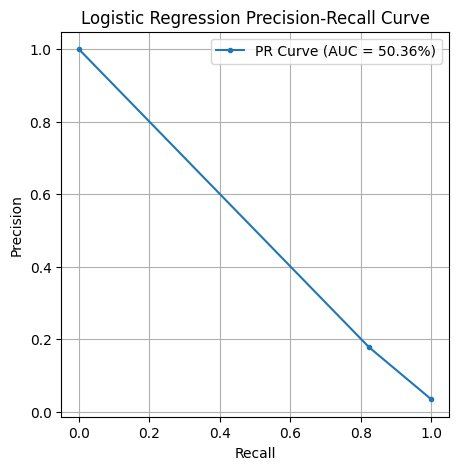

In [75]:
# Make predictions
y_pred_lr= lr.predict(X_test)

metrics = evaluate_model(y_test, y_pred_lr, model_name="Logistic Regression", plot_pr_curve=True)
model_score["Logistic Regression"] = list(metrics.values())

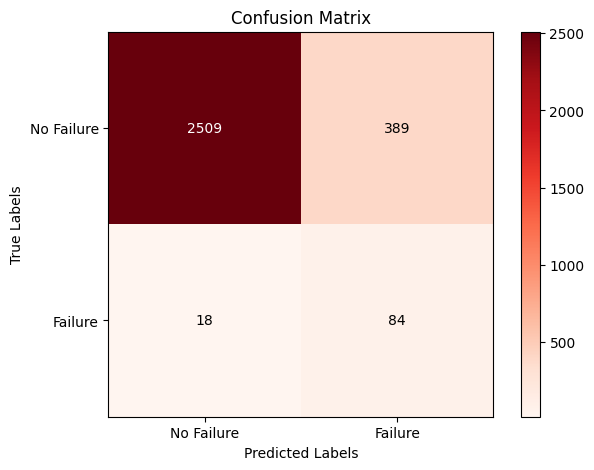

In [76]:
lr_cm = confusion_matrix(y_test, y_pred_lr)
plot_confusion_matrix(lr_cm)

#### Interpretation

* Recall for Class 1 (84.46%): This indicates that the model is able to correctly identify 84.46% of the machine failures (class 1), which is quite good.
* Precision for Class 1 (18%): The precision is very low for class 1, meaning that many of the predicted machine failures are false positives.
* The recall for class 1 is high, meaning the model is catching a significant portion of the actual machine failures. However, the precision is very low, meaning that many non-failures are being incorrectly labeled as failures.

#### 2. Support Vector Machine (SVM)

* SVM can handle imbalanced datasets by adjusting the penalty for misclassifying the minority class using the class_weight parameter.
* "rbf" (Radial Basis Function): Default kernel and usually the most effective for non-linear data. It works well when the relationship between classes is not linearly separable.
* gamma: Kernel coefficient for 'rbf'. Higher values lead to a more complex model, which may overfit, while lower values make the model simpler.
* C: Regularization parameter. Default: C=1

In [77]:
from sklearn.svm import SVC

In [78]:
svc = SVC(kernel='rbf', class_weight='balanced', C=1, gamma='scale', random_state=42)
svc.fit(X_train, y_train)

SVC(C=1, class_weight='balanced', random_state=42)

SVM Evaluation Metrics:
Accuracy: 92.8%
F1 Score: 71.47%
Recall: 92.96%
Precision: 65.5%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      2898
           1       0.31      0.93      0.47       102

    accuracy                           0.93      3000
   macro avg       0.65      0.93      0.71      3000
weighted avg       0.97      0.93      0.94      3000


PR AUC: 62.31%


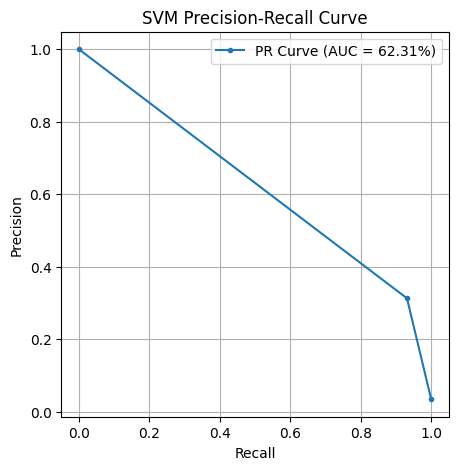

In [79]:
# Make predictions
y_pred_svc = svc.predict(X_test)

metrics = evaluate_model(y_test, y_pred_svc, model_name="SVM", plot_pr_curve=True)
model_score["SVM"] = list(metrics.values())

+ An AUC-PR of 62.31% suggests that, on average, the model performs moderately well in distinguishing between the positive and negative classes.
  
+ High recall, low precision: Curve shows high recall (close to 1), but precision drops significantly as recall increases. This aligns with the model being very good at identifying machine failures (high recall), but many of these predictions are false positives (low precision).

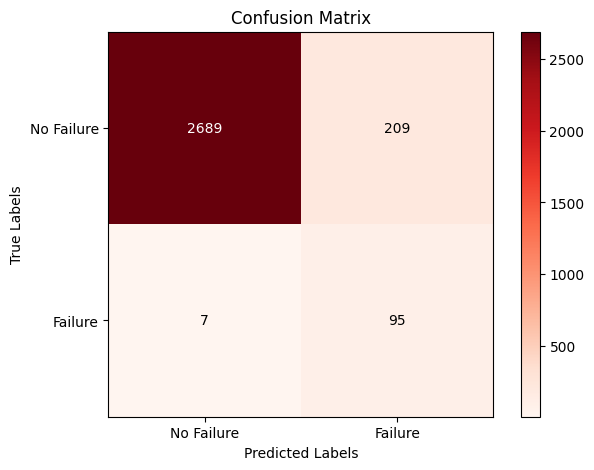

In [80]:
svc_cm = confusion_matrix(y_test, y_pred_svc)
plot_confusion_matrix(svc_cm)

#### Interpretation:

* SVM performed quite well than Logistic Regression.
* Precision((31%) for class 1) got increased from 18% in Logistic Regression, means number of false positives (predicting machine failures that aren't actually failures) decreased.
  
* Will use Tree-Based Models now as they can handle imbalanced data well by adjusting class weights internally.

### Tree-Based Models

#### 3. Random Forest

In [81]:
from sklearn.ensemble import RandomForestClassifier

In [82]:
rf = RandomForestClassifier(class_weight='balanced', random_state=42, 
                        n_estimators=200, bootstrap=True, oob_score=True,)
rf.fit(X_train, y_train)
print("OOB Score:", rf.oob_score_)

OOB Score: 0.9911428571428571


Random Forest Evaluation Metrics:
Accuracy: 99.03%
F1 Score: 91.74%
Recall: 87.2%
Precision: 97.66%

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2898
           1       0.96      0.75      0.84       102

    accuracy                           0.99      3000
   macro avg       0.98      0.87      0.92      3000
weighted avg       0.99      0.99      0.99      3000


PR AUC: 85.79%


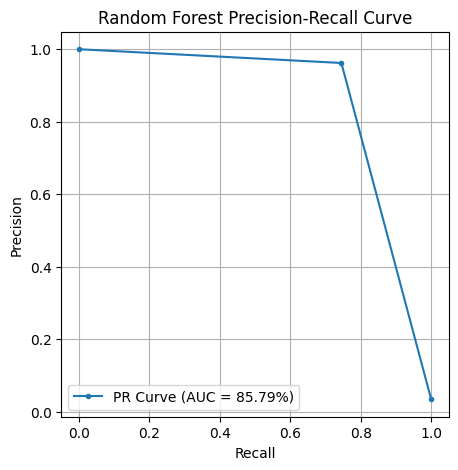

In [83]:
# Make predictions
y_pred_rf = rf.predict(X_test)

metrics = evaluate_model(y_test, y_pred_rf, model_name="Random Forest", plot_pr_curve=True)
model_score["Random Forest"] = list(metrics.values())

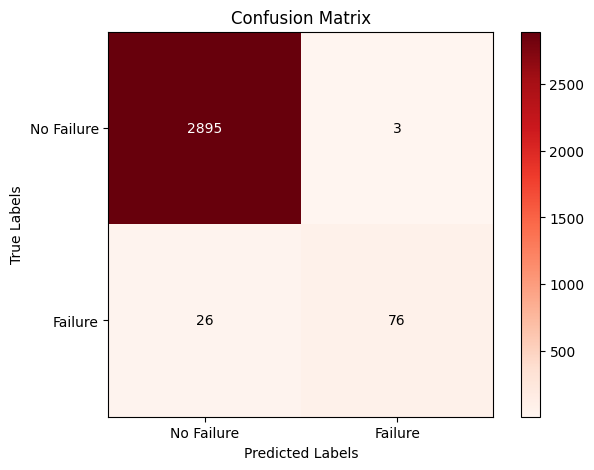

In [84]:
rf_cm = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(rf_cm)

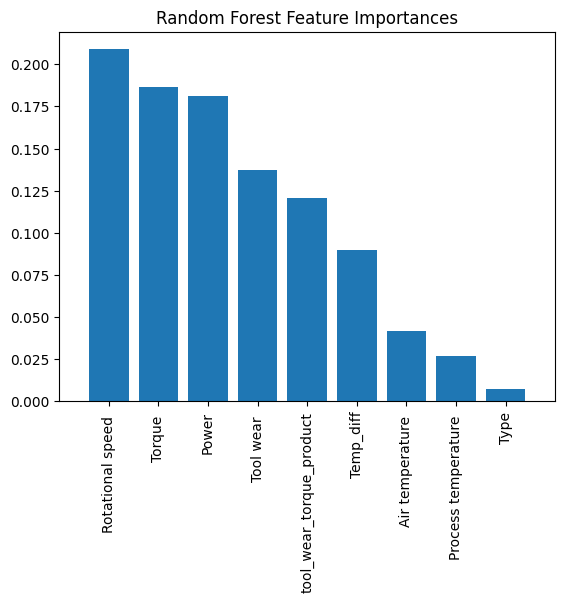

In [120]:
importances = rf.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Random Forest Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

#### Interpretation:
* Precision is 96% for class 1, meaning that of all the instances predicted as failures, 96% were actually failures.
* Recall is 75% for class 1, which means that out of all the actual failures, 75% were correctly detected as failures. This shows that 25% of the actual failures were missed, which are false negatives . Recall got reduced here.
* In machine failure detection, missing true failures can be costly, as undetected failures can lead to significant downtime or damage

* Feature Importance Analysis:  The feature importance rankings revealed that Rotational Speed (0.200) emerged as the most critical factor influencing equipment wear, followed closely by Torque (0.175) and Power (0.150). Other notable features included Tool Wear (0.125) and the interaction term Tool Wear_Torque Product (0.100), indicating the complex relationships between different operational parameters.
* Understanding these importances allows maintenance teams to prioritize monitoring efforts and address critical factors that contribute to equipment degradation.

* Will try with Boosting Methods.

#### Boosting Methods 

#### 4. XGBoost (Extreme Gradient Boosting)

* One of the critical features of XGBoost is its ability to handle missing values and imbalanced data.
* It also performs regularization, which can prevent overfitting. Additionally, XGBoost is fast and scalable.
  
* XGBoost’s scale_pos_weight parameter can directly help handle imbalanced classes by assigning a higher weight to the minority class (class 1 = failure). Here's a formula to compute:
* scale_pos_weight = (number of negative samples) / (number of positive samples)

In [85]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [86]:
# Defining parameter grid for GridSearch
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'scale_pos_weight': [5, 10, 15]  
}

xgb = XGBClassifier( random_state=42, use_label_encoder=False, eval_metric='logloss')

# Apply GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='f1', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [4, 6, 8],
                         'n_estimators': [100, 200, 300],
                         'scale_pos_weight': [5, 10, 15],
                         'subsample': [0.8, 1]},
             scoring='f1', verbose=2)

In [87]:
# Best parameters
print("Best parameters found: ", grid_search.best_params_)

# Make predictions with the best model
best_model_xgb = grid_search.best_estimator_
y_pred_xgb = best_model_xgb.predict(X_test)

Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 200, 'scale_pos_weight': 5, 'subsample': 1}


XGBoost Evaluation Metrics:
Accuracy: 98.9%
F1 Score: 91.59%
Recall: 91.39%
Precision: 91.79%

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2898
           1       0.84      0.83      0.84       102

    accuracy                           0.99      3000
   macro avg       0.92      0.91      0.92      3000
weighted avg       0.99      0.99      0.99      3000


PR AUC: 84.03%


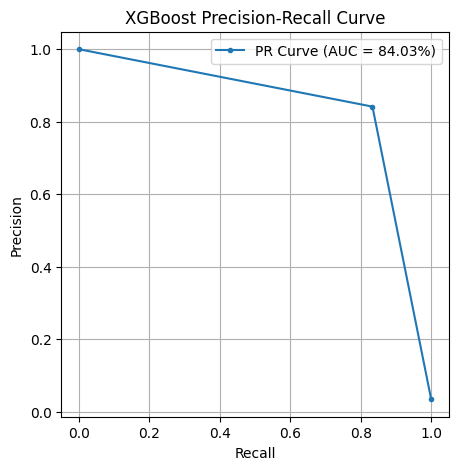

In [88]:
metrics = evaluate_model(y_test, y_pred_xgb, model_name="XGBoost", plot_pr_curve=True)
model_score["XGBoost"] = list(metrics.values())

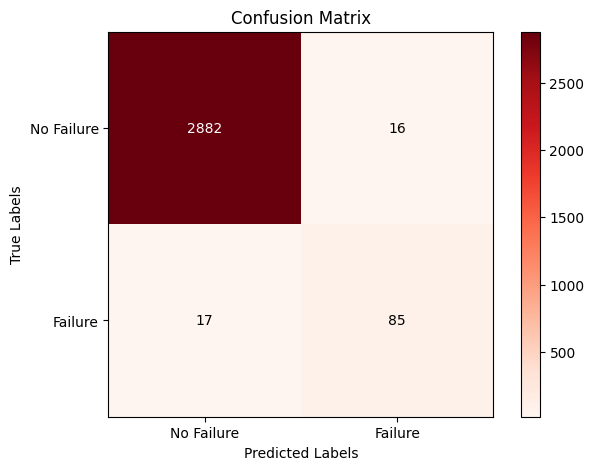

In [89]:
xgb_cm = confusion_matrix(y_test, y_pred_xgb)
plot_confusion_matrix(xgb_cm)

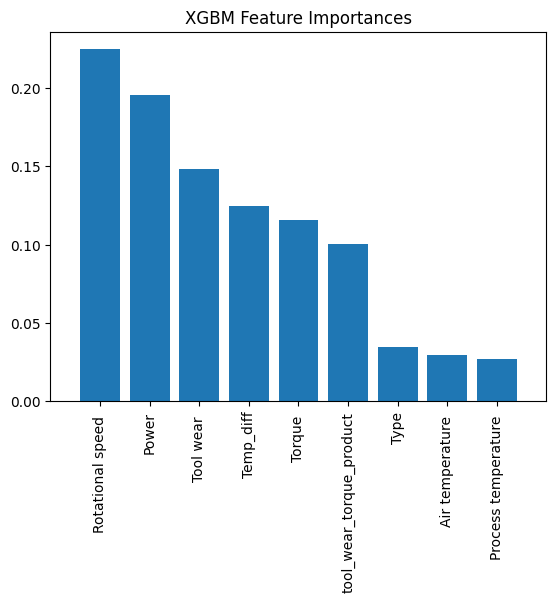

In [110]:
importances = best_model_xgb.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("XGBM Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

#### Interpretation:
* XGBoost model is performing well with high accuracy and a strong balance between precision and recall. The recall for class 1 (failures) is promising.

#### False Negatives got reduced here from 26 in Random Forest to 17 .

#### 5. LightGBM
+ Like XGBoost, LightGBM is a boosting algorithm but optimized for speed and performance.
+ LightGBM uses a unique leaf-wise growth strategy, unlike other boosting algorithms such as XGBoost, which typically use depth-wise or level-wise growth.
+ In a leaf-wise approach, LightGBM grows the tree by splitting the leaf that results in the greatest reduction in loss (i.e., the best fit). 

In [111]:
from lightgbm import LGBMClassifier
import lightgbm as lgb

In [112]:
lgbm = LGBMClassifier(class_weight='balanced', random_state=42)  
lgbm.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 237, number of negative: 6763
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1518
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


LGBMClassifier(class_weight='balanced', random_state=42)

Light GBM Evaluation Metrics:
Accuracy: 98.93%
F1 Score: 91.96%
Recall: 92.35%
Precision: 91.57%

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2898
           1       0.84      0.85      0.84       102

    accuracy                           0.99      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.99      0.99      0.99      3000


PR AUC: 84.72%


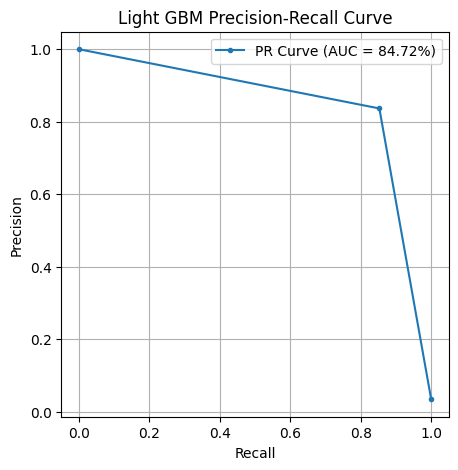

In [92]:
# Make predictions
y_pred_lgbm = lgbm.predict(X_test)

metrics = evaluate_model(y_test, y_pred_lgbm, model_name="Light GBM", plot_pr_curve=True)
model_score["LightGBM"] = list(metrics.values())

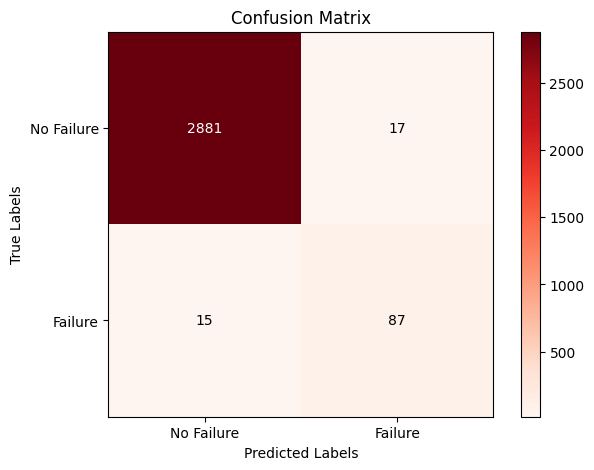

In [93]:
lgbm_cm = confusion_matrix(y_test, y_pred_lgbm)
plot_confusion_matrix(lgbm_cm)

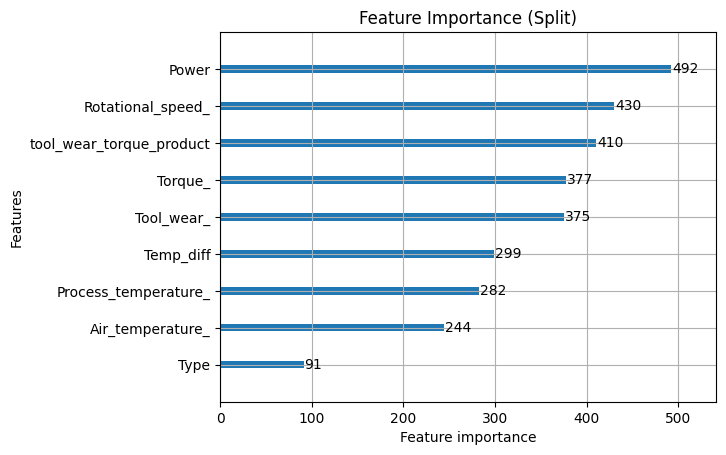

In [113]:
lgb.plot_importance(lgbm, importance_type='split', max_num_features=10, title='Feature Importance (Split)')
plt.show()

#### Interpretation:
+ The precision and recall values for the minority class are respectable, showing that the model is doing a good job of identifying positive cases without too many false positives or negatives.
  
+ Macro avg: Provides the average performance across both classes, treating each class equally. In your case, the macro F1-score, precision, and recall are all around 92%, showing a good overall balance in performance.

+ PR AUC: 84.72%: The Precision-Recall Area Under Curve (PR AUC) of 84.72% indicates how well the model distinguishes between the positive and negative classes, especially in imbalanced datasets. An 84.72% PR AUC is a strong score, suggesting good performance in identifying the minority class (1)

In [94]:
model_score

{'Logistic Regression': [86.43, 60.86, 84.46, 58.52, 50.36],
 'SVM': [92.8, 71.47, 92.96, 65.5, 62.31],
 'Random Forest': [99.03, 91.74, 87.2, 97.66, 85.79],
 'XGBoost': [98.9, 91.59, 91.39, 91.79, 84.03],
 'LightGBM': [98.93, 91.96, 92.35, 91.57, 84.72]}

In [97]:
score_df = pd.DataFrame(model_score).transpose()
score_df.rename(columns = {0 :'Accuracy', 1:'F1' , 2: 'Recall', 3:'precision_score' ,4:'PR AUC(%)'}, inplace = True)
score_df.sort_values(by = 'precision_score', ascending = False, inplace = True)

In [98]:
score_df

,Accuracy,F1,Recall,precision_score,PR AUC(%)
Random Forest,99.03,91.74,87.20,97.66,85.79
XGBoost,98.90,91.59,91.39,91.79,84.03
LightGBM,98.93,91.96,92.35,91.57,84.72
SVM,92.80,71.47,92.96,65.50,62.31
Logistic Regression,86.43,60.86,84.46,58.52,50.36


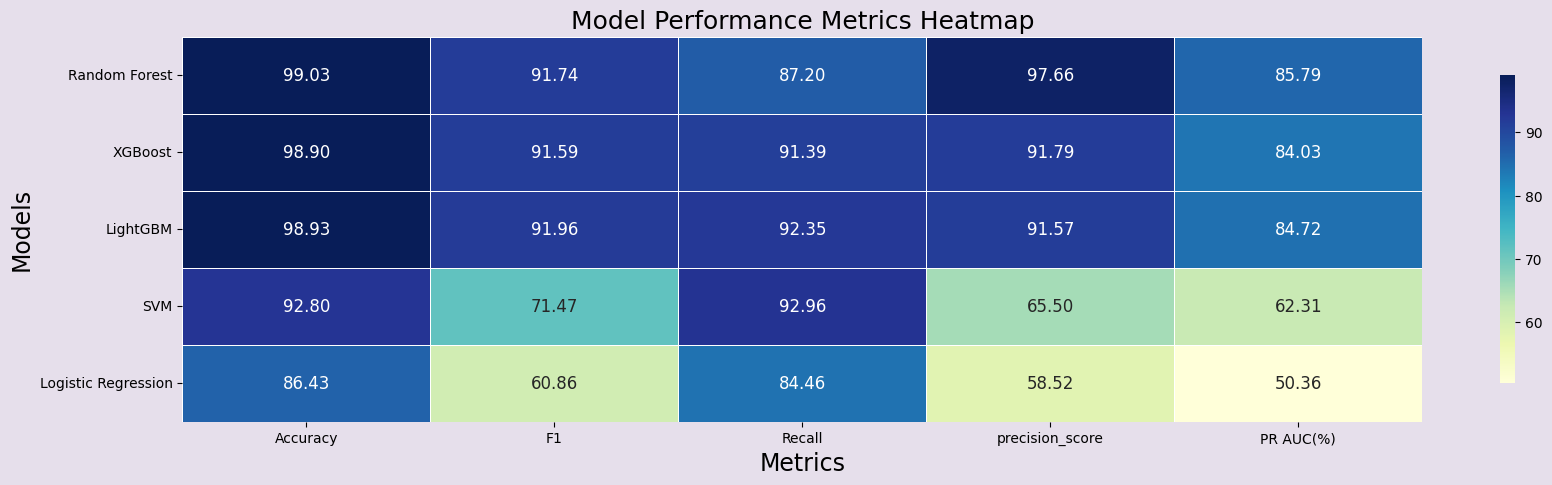

In [99]:
fig = plt.figure(figsize=(20,5), facecolor = '#e6dfeb')
axes = plt.subplot2grid((1,1),(0,0))

sns.heatmap(
    data = score_df, cmap='YlGnBu', annot = True,fmt='.2f', annot_kws={"size": 12},  
    cbar_kws={"shrink": 0.8},  linewidths=0.5,  linecolor='white' ,
      )

plt.xlabel('Metrics', fontsize=17)
plt.ylabel('Models', fontsize=17)
plt.title('Model Performance Metrics Heatmap', fontsize=18)

plt.show()

### Conclusion:

#### In predictive maintenance, both false negatives (missing a failure prediction) and false positives (unnecessary maintenance) are critical considerations.

#### Key Metrics Considerations:
1. Recall: High recall is crucial because I want to ensure that any potential machine failure is detected. Missing a failure can lead to costly downtime and maintenance challenges.
   
2. Precision: High precision is also important because unnecessary maintenance (false positives) can lead to increased operational costs and resource wastage.
   
3. F1 Score: The F1 score balances both recall and precision, making it a useful metric for evaluating models in this context. 


#### Based upon above considerations: 

#### 1. LightGBM has the highest recall (92.35) among the top models, indicating it’s more effective at capturing potential failures (reducing false negatives). Its F1 score (91.96) is also strong, reflecting a good balance between recall and precision.

+ Considerations: While the precision is slightly lower than that of Random Forest, the trade-off may be acceptable given that detecting failures is our primary goal.

#### 2. Random Forest as a Backup:  Random Forest offers the highest precision (97.66) and a very close recall (87.20). This makes it a strong contender if we want to minimize false positives more aggressively while still maintaining a decent level of recall.

+ Considerations: If operational costs due to unnecessary maintenance are a significant concern, Random Forest might be a suitable choice.

#### 3. XGBoost for Balance : XGBoost has a good balance with a high recall (91.39) and competitive precision (91.79). It can be an alternative if we want a slightly different model that still performs well across the board.

+ In this predictive maintenance project, we successfully demonstrated the application of machine learning techniques to foresee potential equipment failures, thereby enhancing operational efficiency and reducing downtime. By leveraging various algorithms such as Random Forest, LightGBM, and XGBoost, we identified key features influencing equipment performance and wear, allowing us to make informed maintenance decisions.
  
+ Feature Importance: The analysis revealed that parameters such as rotational speed, torque, and power play critical roles in predicting equipment wear and failure. These insights can guide maintenance teams to focus on monitoring these factors closely.

+ Model Performance: Through rigorous testing and validation, our models achieved high accuracy and robustness in predicting equipment failures. The LightGBM algorithm, in particular, stood out for its superior performance due to its leaf-wise growth strategy, enabling it to minimize loss more effectively compared to traditional depth-wise methods.

+ Operational Impact: Implementing predictive maintenance strategies can lead to significant cost savings by minimizing unplanned downtime and extending the lifespan of machinery. The transition from reactive to proactive maintenance not only enhances productivity but also contributes to overall safety in operational environments.

+ In conclusion, this project underscores the transformative potential of predictive maintenance in industrial settings, offering a strategic approach to optimize maintenance practices and ensure operational continuity. The insights gained not only pave the way for improved maintenance strategies but also lay the foundation for further innovations in the field.

#### Saving Best 3 Models

In [102]:
import pickle

In [107]:
#Saving the best classifiers
pickle.dump(lgbm, open('Saved_Models/lightgbm.pkl', 'wb'))
pickle.dump(rf, open('Saved_Models/rf.pkl', 'wb'))
pickle.dump(best_model_xgb, open('Saved_Models/xgbm.pkl', 'wb'))